<a href="https://colab.research.google.com/github/bominwang/inviscid-viscid-flow-correct-neural-network/blob/HB-2-surface-pressure/HB_2_SURFACE_PRESSURE_PRED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

无粘网络构建

In [62]:
# 加载谷歌云盘
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# 加载相应模块
import time
import random
import pandas as pd
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD
from torch.autograd import Variable 
import matplotlib.pyplot as plt
import tqdm
from tqdm import trange

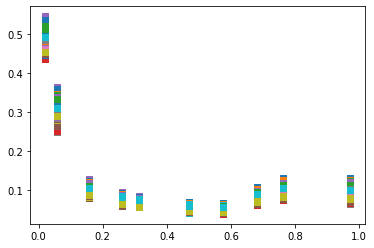

In [64]:
# 加载数据集
ins = pd.read_csv('drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv')
ins = np.array(ins)
labs = pd.read_csv('drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv')
labs = np.array(labs)
positions = labs[:,0].reshape(-1,10)
labs = labs[:,1].reshape(-1,10)
data_size = np.size(labs,0)
# 样本展示
for i in range(data_size):
  position = positions[i, :]
  lab = labs[i, :]
  plt.plot(position, lab, 's')


In [65]:
# 构建训练数据集

data_volume = ins.shape[0]
data_index = list(range(data_volume))
train_volume = 100;
test_volume = data_volume - train_volume
train_index = random.sample(range(0, data_volume), train_volume)
test_index = np.setdiff1d(data_index, train_index)

train_data_ins = torch.from_numpy(ins[train_index, :])
train_data_labs = torch.from_numpy(labs[train_index, :])

test_data_ins = torch.from_numpy(ins[test_index, :])
test_data_labs = torch.from_numpy(labs[test_index, :])

train_set = TensorDataset(train_data_ins, train_data_labs)
train_set = DataLoader(train_set, batch_size = 100, shuffle = True)


In [66]:
# 构建网络结构
class inviscid_nn(nn.Module):
  def __init__(self) -> None:
    super(inviscid_nn, self).__init__()

    self.hidden_layer1 = nn.Sequential(
        nn.Linear(2, 200),
        nn.ReLU()
    )
    self.hidden_layer2 = nn.Sequential(
        nn.Linear(200, 400),
        nn.ReLU()
    )
    self.output_layer = nn.Sequential(
        nn.Linear(400, 10)
    )
  def forward(self, x):
    x = self.hidden_layer1(x)
    x = self.hidden_layer2(x)
    y = self.output_layer(x)
    return y

# 实例化无粘网络
inviscid_model = inviscid_nn()

In [67]:
# 构建相对误差损失函数
def relative_root_mean_squared_error(pred, true):
  size = pred.size(dim = 1)
  error = torch.zeros(size, 1)
  normalization_factor = torch.zeros(size, 1)
  for index in range(size):
    pred_element = pred[index, :]
    true_element = true[index, :]
    error[index, :] = torch.dot(pred_element - true_element, pred_element - true_element)
    normalization_factor[index,:] = torch.dot(true_element, true_element)
  return torch.sqrt(torch.div(torch.sum(error),torch.sum(normalization_factor)))

100%|██████████| 5000/5000 [00:23<00:00, 214.46it/s]



无粘网络训练损失函数收敛于0.00020991888595744967

无粘网络测试集损失函数收敛于0.07174863666296005


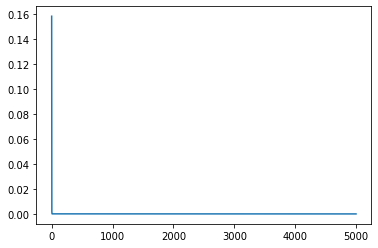

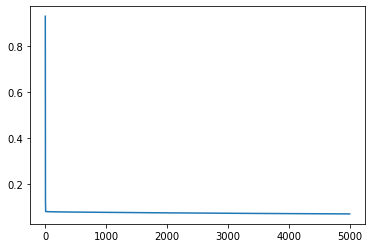

In [68]:
# 训练无粘网络
optimizer = SGD(inviscid_model.parameters(), lr = 0.01)
#loss_function = nn.SmoothL1Loss()
loss_function = nn.MSELoss()

train_loss_history = []
test_loss_history = []

for epoch in trange(5000):
  for index,(ins, lab) in enumerate(train_set):
        ins = Variable(ins).reshape(-1,2).to(torch.float32)
        lab = Variable(lab).reshape(-1,10).to(torch.float32)
        # 反向传播
        inviscid_model.train()
        pred = inviscid_model(ins)
        loss = loss_function(pred, lab)
        #loss = relative_root_mean_squared_error(pred, lab)
        train_loss_history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 测试集误差
        inviscid_model.eval()
        pred = inviscid_model(test_data_ins.reshape(-1,2).to(torch.float32))
        #loss = loss_function(pred, test_data_labs.reshape(-1,10).to(torch.float32))
        loss = relative_root_mean_squared_error(pred, test_data_labs.reshape(-1,10).to(torch.float32))
        test_loss_history.append(loss.item())
plt.figure(2)
plt.plot(train_loss_history)
print(f'\n无粘网络训练损失函数收敛于{train_loss_history[-1]}')
plt.figure(3)
plt.plot(test_loss_history)
print(f'\n无粘网络测试集损失函数收敛于{test_loss_history[-1]}')

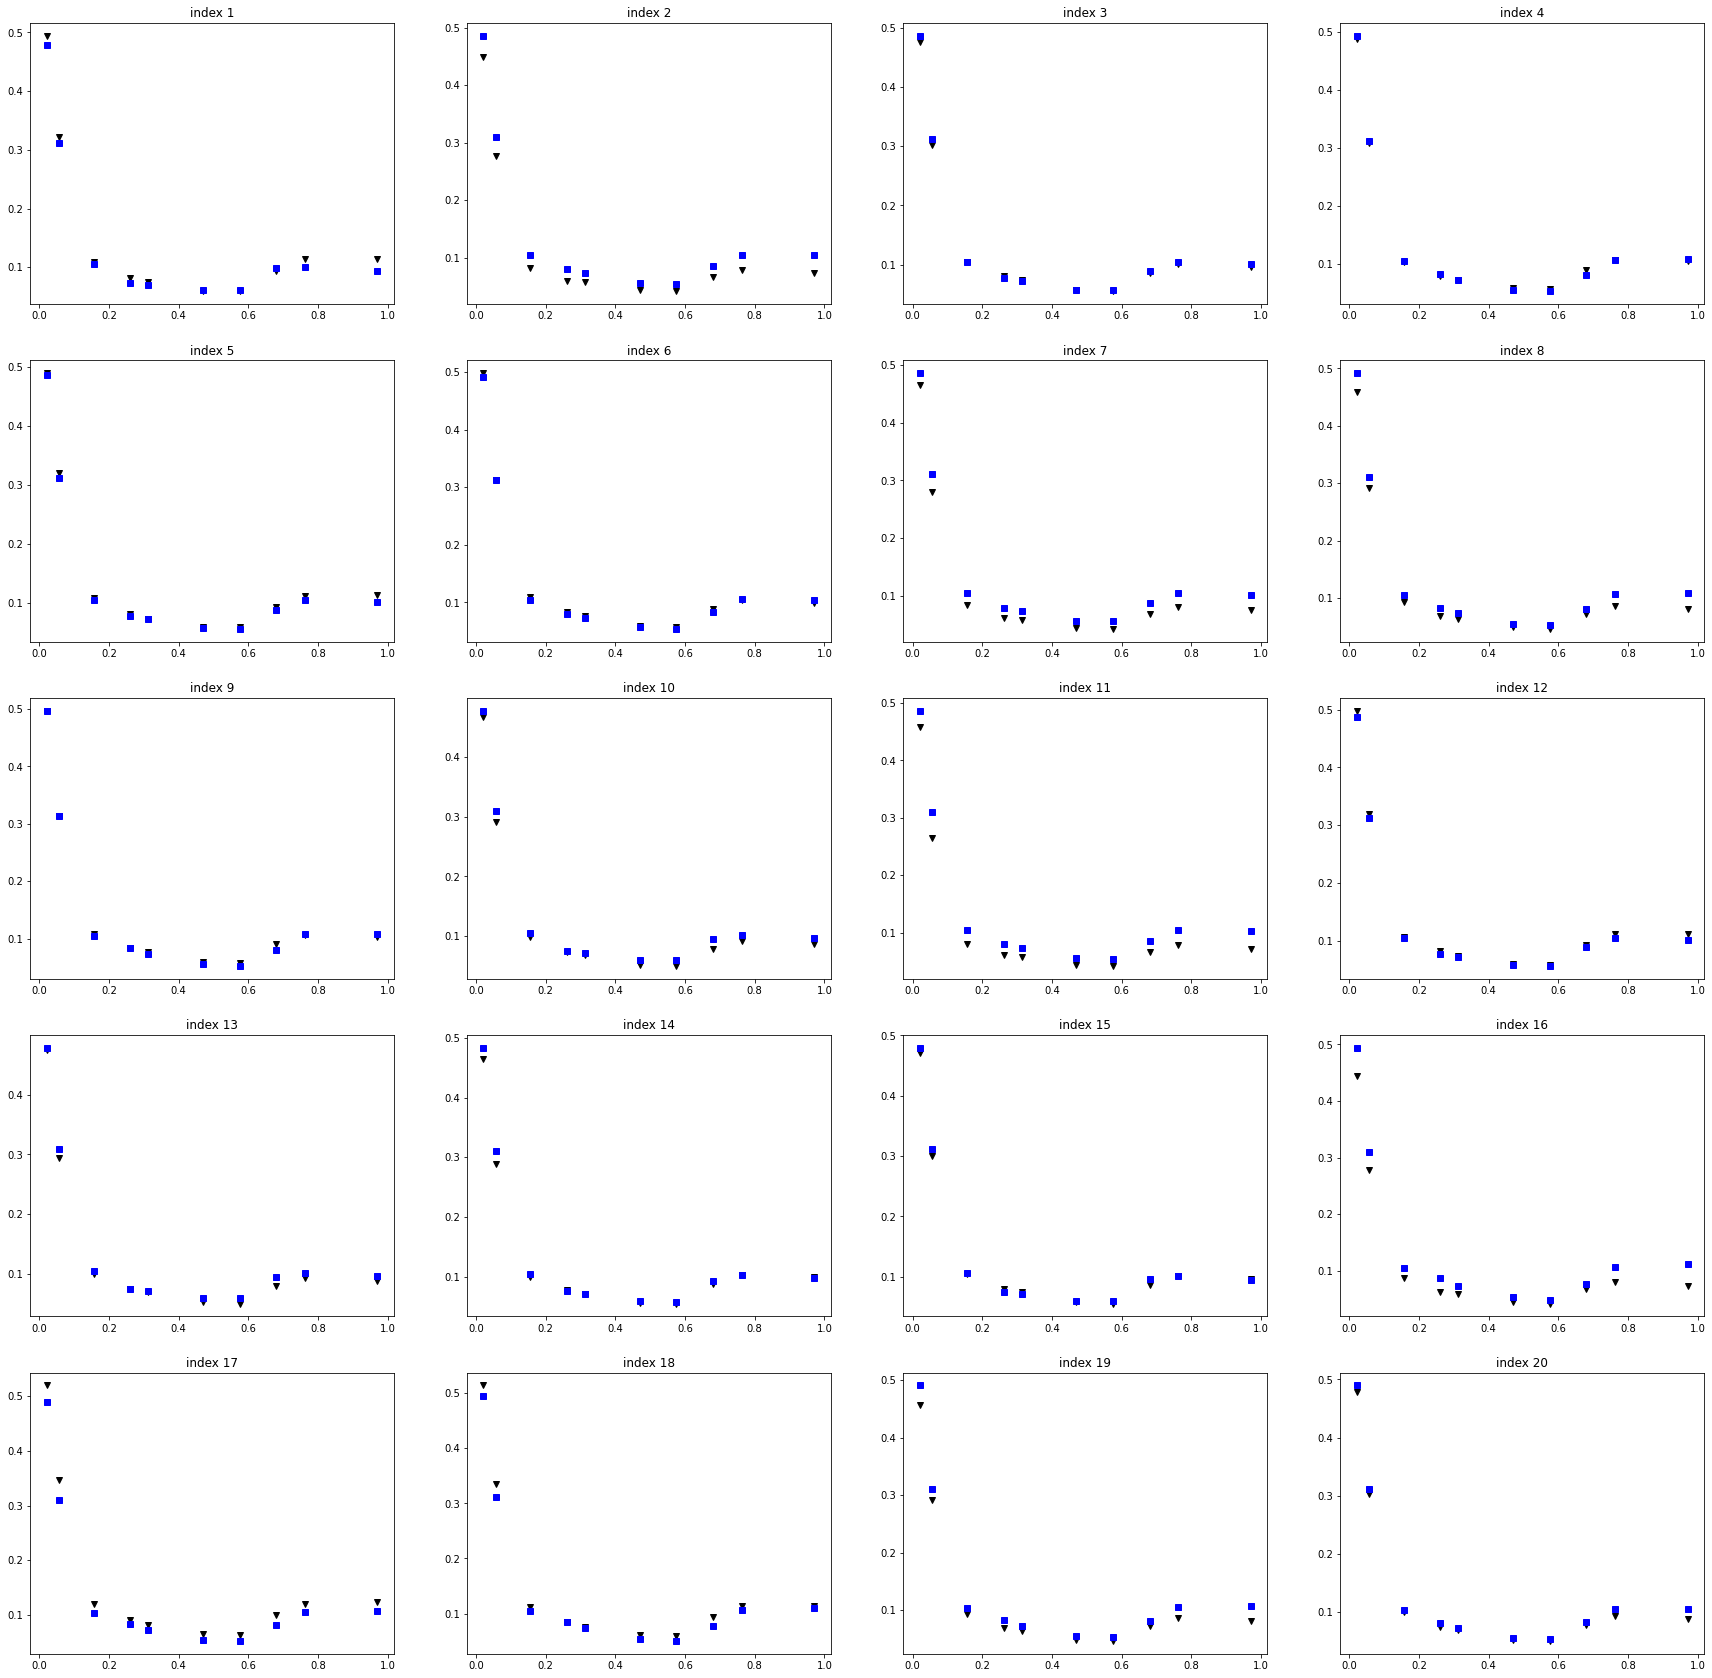

In [69]:
# 输出合理性验证
# 黑色为试验数据
# 蓝色为网络预测数据
inviscid_model.eval()
position = positions[1, :].reshape(1,-1)
index = random.sample(range(0, test_volume), 20)
val_ins = test_data_ins[index, :]
val_labs = test_data_labs[index, :]
val_pred = inviscid_model(val_ins.reshape(-1, 2).to(torch.float32))
plt.figure(figsize=(30, 30))
fig1 = plt.subplot(5, 4, 1)
plt.plot(position, val_labs[0, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[0, :].reshape(1,10).detach().numpy(),'bs')
fig1.set_title('index 1')
fig2 = plt.subplot(5, 4, 2)
plt.plot(position, val_labs[1, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[1, :].reshape(1,10).detach().numpy(),'bs')
fig2.set_title('index 2')
fig3 = plt.subplot(5, 4, 3)
plt.plot(position, val_labs[2, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[2, :].reshape(1,10).detach().numpy(),'bs')
fig3.set_title('index 3')
fig4 = plt.subplot(5, 4, 4)
plt.plot(position, val_labs[3, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[3, :].reshape(1,10).detach().numpy(),'bs')
fig4.set_title('index 4')
fig5 = plt.subplot(5, 4, 5)
plt.plot(position, val_labs[4, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[4, :].reshape(1,10).detach().numpy(),'bs')
fig5.set_title('index 5')
fig6 = plt.subplot(5, 4, 6)
plt.plot(position, val_labs[5, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[5, :].reshape(1,10).detach().numpy(),'bs')
fig6.set_title('index 6')
fig7 = plt.subplot(5, 4, 7)
plt.plot(position, val_labs[6, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[6, :].reshape(1,10).detach().numpy(),'bs')
fig7.set_title('index 7')
fig8 = plt.subplot(5, 4, 8)
plt.plot(position, val_labs[7, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[7, :].reshape(1,10).detach().numpy(),'bs')
fig8.set_title('index 8')
fig9 = plt.subplot(5, 4, 9)
plt.plot(position, val_labs[8, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[8, :].reshape(1,10).detach().numpy(),'bs')
fig9.set_title('index 9')
fig10 = plt.subplot(5, 4, 10)
plt.plot(position, val_labs[9, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[9, :].reshape(1,10).detach().numpy(),'bs')
fig10.set_title('index 10')
fig11 = plt.subplot(5, 4, 11)
plt.plot(position, val_labs[10, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[10, :].reshape(1,10).detach().numpy(),'bs')
fig11.set_title('index 11')
fig12 = plt.subplot(5, 4, 12)
plt.plot(position, val_labs[11, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[11, :].reshape(1,10).detach().numpy(),'bs')
fig12.set_title('index 12')
fig13 = plt.subplot(5, 4, 13)
plt.plot(position, val_labs[12, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[12, :].reshape(1,10).detach().numpy(),'bs')
fig13.set_title('index 13')
fig14 = plt.subplot(5, 4, 14)
plt.plot(position, val_labs[13, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[13, :].reshape(1,10).detach().numpy(),'bs')
fig14.set_title('index 14') 
fig15 = plt.subplot(5, 4, 15)
plt.plot(position, val_labs[14, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[14, :].reshape(1,10).detach().numpy(),'bs')
fig15.set_title('index 15')
fig16 = plt.subplot(5, 4, 16)
plt.plot(position, val_labs[15, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[15, :].reshape(1,10).detach().numpy(),'bs')
fig16.set_title('index 16')
fig17 = plt.subplot(5, 4, 17)
plt.plot(position, val_labs[16, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[16, :].reshape(1,10).detach().numpy(),'bs')
fig17.set_title('index 17')
fig18 = plt.subplot(5, 4, 18)
plt.plot(position, val_labs[17, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[17, :].reshape(1,10).detach().numpy(),'bs')
fig18.set_title('index 18')
fig19 = plt.subplot(5, 4, 19)
plt.plot(position, val_labs[18, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[18, :].reshape(1,10).detach().numpy(),'bs')
fig19.set_title('index 19')
fig20 = plt.subplot(5, 4, 20)
plt.plot(position, val_labs[19, :].reshape(1,10).detach().numpy(),'kv')
plt.plot(position, val_pred[19, :].reshape(1,10).detach().numpy(),'bs')
fig20.set_title('index 20')
plt.show()

粘性网络构建

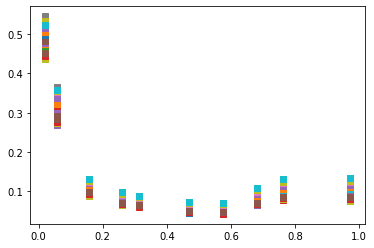

In [70]:
# 加载数据集
ins = pd.read_csv('drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/sa/sa_input_data.csv')
ins = np.array(ins)
labs = pd.read_csv('drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/sa/sa_output_data.csv')
labs = np.array(labs)
positions = labs[:,0].reshape(-1,10)
labs = labs[:,1].reshape(-1,10)
data_size = np.size(labs,0)
# 样本展示
for i in range(data_size):
  position = positions[i, :]
  lab = labs[i, :]
  plt.plot(position, lab, 's')

In [71]:
# 构建训练数据集
data_volume = ins.shape[0]
data_index = list(range(data_volume))
train_volume = 20;
test_volume = data_volume - train_volume
train_index = random.sample(range(0, data_volume), train_volume)
test_index = np.setdiff1d(data_index, train_index)

train_data_ins = torch.from_numpy(ins[train_index, :])
train_data_labs = torch.from_numpy(labs[train_index, :])

test_data_ins = torch.from_numpy(ins[test_index, :])
test_data_labs = torch.from_numpy(labs[test_index, :])

train_set = TensorDataset(train_data_ins, train_data_labs)
train_set = DataLoader(train_set, batch_size = 100, shuffle = True)

In [72]:
class sa_nn(nn.Module):
  def __init__(self, inviscid_model) -> None:
    super(sa_nn, self).__init__()
    
    self.inviscid_model = inviscid_model
    for preas in self.inviscid_model.parameters():
      preas.requires_grad=False

    self.hidden_layer1 = nn.Sequential(
        nn.Linear(7, 98),
        nn.ReLU()
    )
    self.hidden_layer2 = nn.Sequential(
        nn.Linear(98, 196),
        nn.ReLU()
    )
    self.output_layer = nn.Sequential(
        nn.Linear(206, 10)
    )
  def forward(self, x):
    x1 = x[:, 0:2]
    x2 = x[:, 2:10]
    x2 = self.hidden_layer1(x2)
    x2 = self.hidden_layer2(x2)
    x1 = self.inviscid_model(x1)
    x = torch.cat([x1,x2],1)
    y = self.output_layer(x)
    return y

# 实例化无粘网络
sa_model = sa_nn(inviscid_model)

100%|██████████| 5000/5000 [00:13<00:00, 373.57it/s]



无粘网络训练损失函数收敛于0.00023877937928773463

无粘网络测试集损失函数收敛于0.0002997647097799927


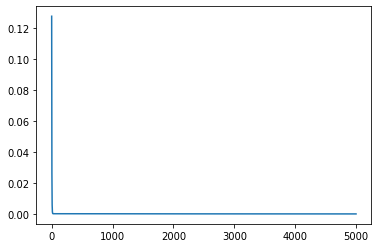

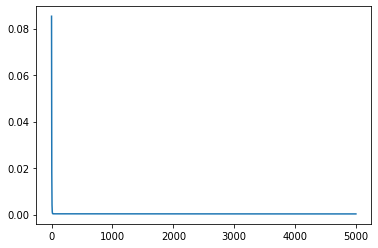

In [73]:
# 训练无粘网络
optimizer = SGD(sa_model.parameters(), lr = 0.01)
# loss_function = nn.SmoothL1Loss()
loss_function = nn.MSELoss()
train_loss_history = []
test_loss_history = []

for epoch in trange(5000):
  for index,(ins, lab) in enumerate(train_set):
        ins = Variable(ins).reshape(-1,9).to(torch.float32)
        lab = Variable(lab).reshape(-1,10).to(torch.float32)
        # 反向传播
        sa_model.train()
        pred = sa_model(ins)
        loss = loss_function(pred, lab)
        train_loss_history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 测试集误差
        sa_model.eval()
        pred = sa_model(test_data_ins.reshape(-1,9).to(torch.float32))
        loss = loss_function(pred, test_data_labs.reshape(-1,10).to(torch.float32))
        test_loss_history.append(loss.item())
plt.figure(2)
plt.plot(train_loss_history)
print(f'\n无粘网络训练损失函数收敛于{train_loss_history[-1]}')
plt.figure(3)
plt.plot(test_loss_history)
print(f'\n无粘网络测试集损失函数收敛于{test_loss_history[-1]}')

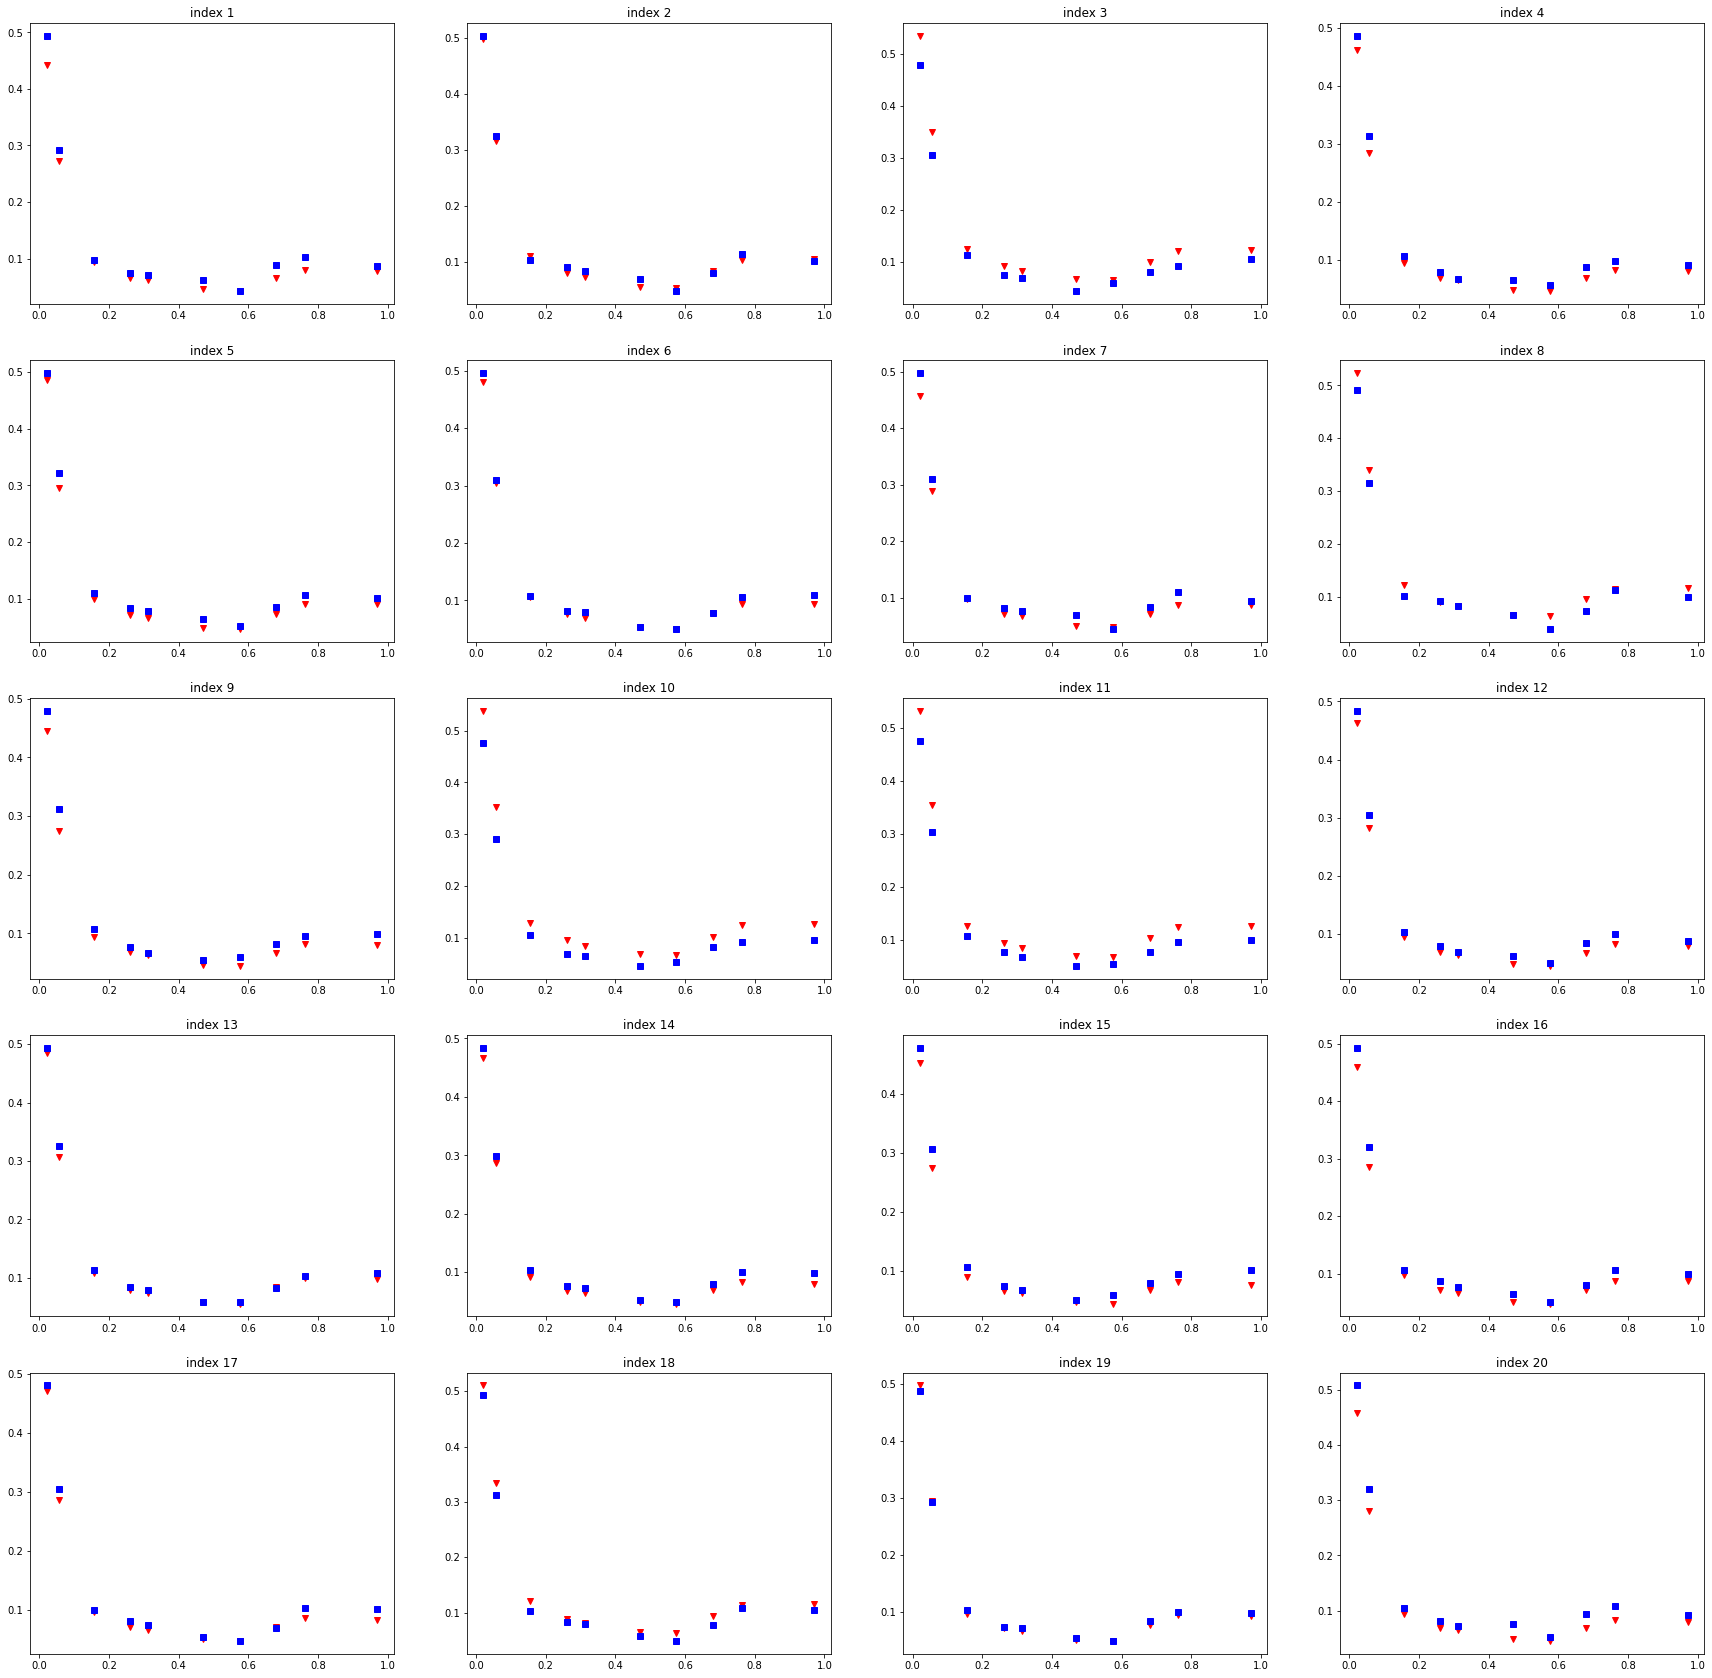

In [74]:
# 输出合理性验证
# 红色为模拟试验数据
# 蓝色为网络预测数据
sa_model.eval()
position = positions[2, :].reshape(1,-1)
index = random.sample(range(0, test_volume), 20)
val_ins = test_data_ins[index, :]
val_labs = test_data_labs[index, :]
val_pred = sa_model(val_ins.reshape(-1, 9).to(torch.float32))
plt.figure(figsize=(30, 30))
fig1 = plt.subplot(5, 4, 1)
plt.plot(position, val_labs[0, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[0, :].reshape(1,10).detach().numpy(),'bs')
fig1.set_title('index 1')
fig2 = plt.subplot(5, 4, 2)
plt.plot(position, val_labs[1, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[1, :].reshape(1,10).detach().numpy(),'bs')
fig2.set_title('index 2')
fig3 = plt.subplot(5, 4, 3)
plt.plot(position, val_labs[2, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[2, :].reshape(1,10).detach().numpy(),'bs')
fig3.set_title('index 3')
fig4 = plt.subplot(5, 4, 4)
plt.plot(position, val_labs[3, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[3, :].reshape(1,10).detach().numpy(),'bs')
fig4.set_title('index 4')
fig5 = plt.subplot(5, 4, 5)
plt.plot(position, val_labs[4, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[4, :].reshape(1,10).detach().numpy(),'bs')
fig5.set_title('index 5')
fig6 = plt.subplot(5, 4, 6)
plt.plot(position, val_labs[5, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[5, :].reshape(1,10).detach().numpy(),'bs')
fig6.set_title('index 6')
fig7 = plt.subplot(5, 4, 7)
plt.plot(position, val_labs[6, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[6, :].reshape(1,10).detach().numpy(),'bs')
fig7.set_title('index 7')
fig8 = plt.subplot(5, 4, 8)
plt.plot(position, val_labs[7, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[7, :].reshape(1,10).detach().numpy(),'bs')
fig8.set_title('index 8')
fig9 = plt.subplot(5, 4, 9)
plt.plot(position, val_labs[8, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[8, :].reshape(1,10).detach().numpy(),'bs')
fig9.set_title('index 9')
fig10 = plt.subplot(5, 4, 10)
plt.plot(position, val_labs[9, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[9, :].reshape(1,10).detach().numpy(),'bs')
fig10.set_title('index 10')
fig11 = plt.subplot(5, 4, 11)
plt.plot(position, val_labs[10, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[10, :].reshape(1,10).detach().numpy(),'bs')
fig11.set_title('index 11')
fig12 = plt.subplot(5, 4, 12)
plt.plot(position, val_labs[11, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[11, :].reshape(1,10).detach().numpy(),'bs')
fig12.set_title('index 12')
fig13 = plt.subplot(5, 4, 13)
plt.plot(position, val_labs[12, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[12, :].reshape(1,10).detach().numpy(),'bs')
fig13.set_title('index 13')
fig14 = plt.subplot(5, 4, 14)
plt.plot(position, val_labs[13, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[13, :].reshape(1,10).detach().numpy(),'bs')
fig14.set_title('index 14') 
fig15 = plt.subplot(5, 4, 15)
plt.plot(position, val_labs[14, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[14, :].reshape(1,10).detach().numpy(),'bs')
fig15.set_title('index 15')
fig16 = plt.subplot(5, 4, 16)
plt.plot(position, val_labs[15, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[15, :].reshape(1,10).detach().numpy(),'bs')
fig16.set_title('index 16')
fig17 = plt.subplot(5, 4, 17)
plt.plot(position, val_labs[16, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[16, :].reshape(1,10).detach().numpy(),'bs')
fig17.set_title('index 17')
fig18 = plt.subplot(5, 4, 18)
plt.plot(position, val_labs[17, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[17, :].reshape(1,10).detach().numpy(),'bs')
fig18.set_title('index 18')
fig19 = plt.subplot(5, 4, 19)
plt.plot(position, val_labs[18, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[18, :].reshape(1,10).detach().numpy(),'bs')
fig19.set_title('index 19')
fig20 = plt.subplot(5, 4, 20)
plt.plot(position, val_labs[19, :].reshape(1,-1),'rv')
plt.plot(position, val_pred[19, :].reshape(1,10).detach().numpy(),'bs')
fig20.set_title('index 20')
plt.show()